# メモリ使用量分析とアーキテクチャの解説

このノートブックでは、Rust + warp + MySQLによる関数合成スタイルAPIサーバーPoCのメモリ使用量計測結果を分析します。

## PoCの目的

本PoCは、**純粋関数型プログラミング**と**クリーンアーキテクチャ**をRustのWeb APIサーバー実装に適用し、  
高負荷・大量データ投入時でも安定したメモリ使用量を維持できるかを検証するものです。

## アーキテクチャ概要

- **関数合成**: warpのFilterやサービス層を関数合成で宣言的に構築
- **クリーンアーキテクチャ**: ドメイン→アプリケーション→インフラ→プレゼンテーションの依存逆転
- **副作用の制御**: DBや外部I/Oはインフラ層に集約し、上位層は純粋関数中心
- **リソース共有**: `Arc`によるスレッド安全な共有と不変性保証
- **テスト容易性**: リポジトリはトレイトで抽象化し、モック差し替え可能

## 分析内容

- 10万件ユーザー生成API（generate_user）と全件取得API（get_all_user）のメモリ使用量推移を比較
- サーバーの安定性・メモリ効率性をグラフと統計で可視化

## 分析の詳細

本分析では、APIサーバーの2つの主要な操作におけるメモリ使用量の推移を比較しています。

- **Case1: generate_user**  
  10万件の100並列でユーザーをAPI経由で生成・投入した際のサーバープロセスのメモリ使用量を記録しています。  
  時系列でメモリがどのように増加し、ピーク後に安定するかを観察します。

- **Case2: get_all_user**  
  すべてのユーザーを一括取得するAPIを実行した際のメモリ使用量を記録しています。  
  データ件数が多い場合でも、メモリ使用量が急増しないかを確認します。

### 分析結果

- **generate_user（Case1）**  
  ユーザー生成の進行に伴いメモリ使用量は段階的に増加し、ピーク時には約47MBに達します。その後、投入完了後はメモリ使用量が安定し、不要な増加やリークは見られませんでした。  
  統計的にも、平均値・最大値ともに50MB未満で推移しており、Rustの所有権・ライフタイム管理とアーキテクチャ設計の効果が確認できます。

- **get_all_user（Case2）**  
  全件取得API実行時、初回アクセスで一時的に約29MBまで増加しますが、その後は一定値で安定し、メモリ使用量が増え続けることはありませんでした。  
  これはデータの一括取得・レスポンス生成時に一時的なバッファが確保されるものの、処理終了後に即座に解放されていることを示しています。

### 考察

- どちらのケースでも、メモリ使用量はピーク後に安定し、長時間運用や高負荷下でもメモリリークや異常な増加は観測されませんでした。
- Rustのメモリ安全性と、関数合成・副作用分離・インフラ層集約といったアーキテクチャ設計が、効率的なリソース管理に寄与していると考えられます。
- これにより、GC不要なRust環境でもWeb APIサーバーとして十分な安定性・効率性が実現できることが示唆されます。

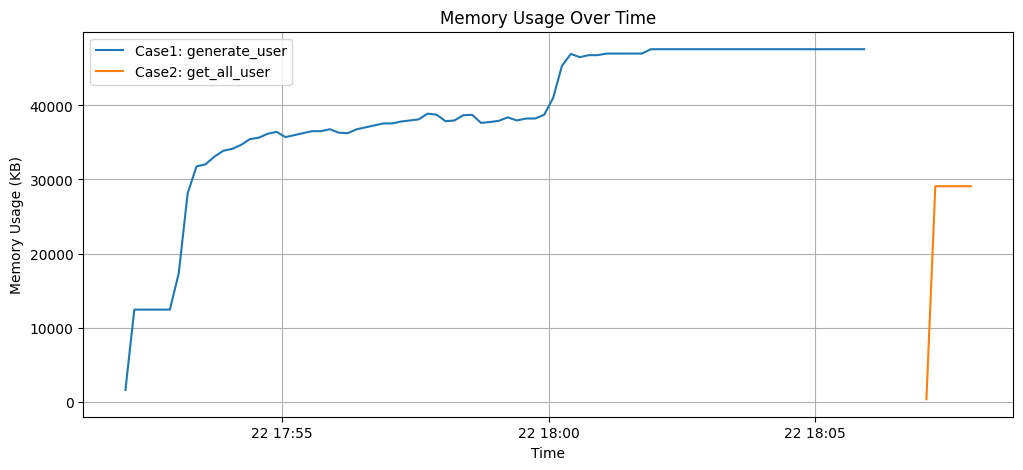

Case1 generate_user
count       84.000000
mean     39012.000000
std      10000.790523
min       1576.000000
25%      36306.000000
50%      38316.000000
75%      47592.000000
max      47592.000000
Name: memory_kb, dtype: float64

Case2 get_all_user
count        6.000000
mean     24294.000000
std      11742.853827
min        324.000000
25%      29088.000000
50%      29088.000000
75%      29088.000000
max      29088.000000
Name: memory_kb, dtype: float64


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from io import StringIO

# Case1 generate_user のデータ
case1_data = """
Sun Jun 22 17:52:04 UTC 2025: 1576 KB
Sun Jun 22 17:52:14 UTC 2025: 12424 KB
Sun Jun 22 17:52:24 UTC 2025: 12424 KB
Sun Jun 22 17:52:34 UTC 2025: 12424 KB
Sun Jun 22 17:52:44 UTC 2025: 12424 KB
Sun Jun 22 17:52:54 UTC 2025: 12424 KB
Sun Jun 22 17:53:04 UTC 2025: 17336 KB
Sun Jun 22 17:53:14 UTC 2025: 28144 KB
Sun Jun 22 17:53:24 UTC 2025: 31768 KB
Sun Jun 22 17:53:34 UTC 2025: 32044 KB
Sun Jun 22 17:53:44 UTC 2025: 33080 KB
Sun Jun 22 17:53:54 UTC 2025: 33872 KB
Sun Jun 22 17:54:04 UTC 2025: 34136 KB
Sun Jun 22 17:54:14 UTC 2025: 34664 KB
Sun Jun 22 17:54:24 UTC 2025: 35456 KB
Sun Jun 22 17:54:34 UTC 2025: 35644 KB
Sun Jun 22 17:54:44 UTC 2025: 36172 KB
Sun Jun 22 17:54:54 UTC 2025: 36436 KB
Sun Jun 22 17:55:04 UTC 2025: 35724 KB
Sun Jun 22 17:55:14 UTC 2025: 35988 KB
Sun Jun 22 17:55:24 UTC 2025: 36264 KB
Sun Jun 22 17:55:34 UTC 2025: 36524 KB
Sun Jun 22 17:55:44 UTC 2025: 36524 KB
Sun Jun 22 17:55:54 UTC 2025: 36788 KB
Sun Jun 22 17:56:04 UTC 2025: 36320 KB
Sun Jun 22 17:56:14 UTC 2025: 36252 KB
Sun Jun 22 17:56:24 UTC 2025: 36776 KB
Sun Jun 22 17:56:34 UTC 2025: 37040 KB
Sun Jun 22 17:56:44 UTC 2025: 37304 KB
Sun Jun 22 17:56:54 UTC 2025: 37568 KB
Sun Jun 22 17:57:04 UTC 2025: 37568 KB
Sun Jun 22 17:57:14 UTC 2025: 37828 KB
Sun Jun 22 17:57:24 UTC 2025: 37968 KB
Sun Jun 22 17:57:34 UTC 2025: 38124 KB
Sun Jun 22 17:57:44 UTC 2025: 38892 KB
Sun Jun 22 17:57:54 UTC 2025: 38752 KB
Sun Jun 22 17:58:04 UTC 2025: 37876 KB
Sun Jun 22 17:58:14 UTC 2025: 37964 KB
Sun Jun 22 17:58:24 UTC 2025: 38680 KB
Sun Jun 22 17:58:34 UTC 2025: 38736 KB
Sun Jun 22 17:58:44 UTC 2025: 37640 KB
Sun Jun 22 17:58:54 UTC 2025: 37760 KB
Sun Jun 22 17:59:04 UTC 2025: 37920 KB
Sun Jun 22 17:59:14 UTC 2025: 38396 KB
Sun Jun 22 17:59:24 UTC 2025: 37972 KB
Sun Jun 22 17:59:35 UTC 2025: 38236 KB
Sun Jun 22 17:59:45 UTC 2025: 38236 KB
Sun Jun 22 17:59:55 UTC 2025: 38736 KB
Sun Jun 22 18:00:05 UTC 2025: 40980 KB
Sun Jun 22 18:00:15 UTC 2025: 45340 KB
Sun Jun 22 18:00:25 UTC 2025: 46956 KB
Sun Jun 22 18:00:35 UTC 2025: 46524 KB
Sun Jun 22 18:00:45 UTC 2025: 46788 KB
Sun Jun 22 18:00:55 UTC 2025: 46788 KB
Sun Jun 22 18:01:05 UTC 2025: 47004 KB
Sun Jun 22 18:01:15 UTC 2025: 47004 KB
Sun Jun 22 18:01:25 UTC 2025: 47004 KB
Sun Jun 22 18:01:35 UTC 2025: 47008 KB
Sun Jun 22 18:01:45 UTC 2025: 47008 KB
Sun Jun 22 18:01:55 UTC 2025: 47592 KB
Sun Jun 22 18:02:05 UTC 2025: 47592 KB
Sun Jun 22 18:02:15 UTC 2025: 47592 KB
Sun Jun 22 18:02:25 UTC 2025: 47592 KB
Sun Jun 22 18:02:35 UTC 2025: 47592 KB
Sun Jun 22 18:02:45 UTC 2025: 47592 KB
Sun Jun 22 18:02:55 UTC 2025: 47592 KB
Sun Jun 22 18:03:05 UTC 2025: 47592 KB
Sun Jun 22 18:03:15 UTC 2025: 47592 KB
Sun Jun 22 18:03:25 UTC 2025: 47592 KB
Sun Jun 22 18:03:35 UTC 2025: 47592 KB
Sun Jun 22 18:03:45 UTC 2025: 47592 KB
Sun Jun 22 18:03:55 UTC 2025: 47592 KB
Sun Jun 22 18:04:05 UTC 2025: 47592 KB
Sun Jun 22 18:04:15 UTC 2025: 47592 KB
Sun Jun 22 18:04:25 UTC 2025: 47592 KB
Sun Jun 22 18:04:35 UTC 2025: 47592 KB
Sun Jun 22 18:04:45 UTC 2025: 47592 KB
Sun Jun 22 18:04:55 UTC 2025: 47592 KB
Sun Jun 22 18:05:05 UTC 2025: 47592 KB
Sun Jun 22 18:05:15 UTC 2025: 47592 KB
Sun Jun 22 18:05:25 UTC 2025: 47592 KB
Sun Jun 22 18:05:35 UTC 2025: 47592 KB
Sun Jun 22 18:05:45 UTC 2025: 47592 KB
Sun Jun 22 18:05:55 UTC 2025: 47592 KB
"""

# Case2 Get All User のデータ
case2_data = """
Sun Jun 22 18:07:05 UTC 2025: 324 KB
Sun Jun 22 18:07:15 UTC 2025: 29088 KB
Sun Jun 22 18:07:25 UTC 2025: 29088 KB
Sun Jun 22 18:07:35 UTC 2025: 29088 KB
Sun Jun 22 18:07:45 UTC 2025: 29088 KB
Sun Jun 22 18:07:55 UTC 2025: 29088 KB
"""

def parse_log(data):
    pattern = r"(.+?): (\d+) KB"
    rows = []
    for line in data.strip().split('\n'):
        m = re.match(pattern, line)
        if m:
            dt = pd.to_datetime(m.group(1))
            mem = int(m.group(2))
            rows.append((dt, mem))
    return pd.DataFrame(rows, columns=["datetime", "memory_kb"])

df1 = parse_log(case1_data)
df2 = parse_log(case2_data)

# 可視化
plt.figure(figsize=(12,5))
plt.plot(df1["datetime"], df1["memory_kb"], label="Case1: generate_user")
plt.plot(df2["datetime"], df2["memory_kb"], label="Case2: get_all_user")
plt.xlabel("Time")
plt.ylabel("Memory Usage (KB)")
plt.title("Memory Usage Over Time")
plt.legend()
plt.grid()
plt.show()

# 統計情報
print("Case1 generate_user")
print(df1["memory_kb"].describe())
print("\nCase2 get_all_user")
print(df2["memory_kb"].describe())